In [1]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
import torch

# Assuming your model is a PyTorch model and you want to load its state dictionary
model_path = '/content/unet_model_final.pth'
try:
    # Load the model state dictionary
    state_dict = torch.load(model_path)

    # You would then typically load this state dictionary into your model instance
    # model.load_state_dict(state_dict)
    print(f"Successfully loaded model state dictionary from {model_path}")

except FileNotFoundError:
    print(f"Error: The file {model_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Successfully loaded model state dictionary from /content/unet_model_final.pth


In [9]:
!pip install torch torchvision matplotlib pillow numpy tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
import random

print(f'PyTorch version: {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


PyTorch version: 2.6.0+cu124
Using device: cpu


In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=65, out_channels=3):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        # Final layer
        self.final = nn.Conv2d(64, out_channels, 1)

        # Color embedding
        self.color_embedding = nn.Embedding(8, 64)

    def forward(self, x, color_idx):
        # Get color embedding
        color_emb = self.color_embedding(color_idx)

        # Expand color embedding to match spatial dimensions
        batch_size, _, height, width = x.shape
        color_emb = color_emb.unsqueeze(-1).unsqueeze(-1)
        color_emb = color_emb.expand(batch_size, 64, height, width)

        # Concatenate input image with color embedding
        x = torch.cat([x, color_emb], dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)

        # Final output
        output = torch.sigmoid(self.final(dec1))
        return output

In [11]:
class PolygonDataset(Dataset):
    def __init__(self, data_json, transform=None, image_size=128):
        """
        Dataset for polygon colorization

        Args:
            data_json: List of dictionaries with 'input_polygon', 'colour', 'output_image'
            transform: Optional transforms to apply
            image_size: Size to resize images to
        """
        self.data = data_json
        self.transform = transform
        self.image_size = image_size

        # Color mapping
        self.color_map = {
            'cyan': 0, 'purple': 1, 'magenta': 2, 'green': 3,
            'red': 4, 'blue': 5, 'yellow': 6, 'orange': 7
        }

        # RGB values for each color
        self.color_rgb = {
            'cyan': [0, 1, 1],
            'purple': [0.5, 0, 0.5],
            'magenta': [1, 0, 1],
            'green': [0, 1, 0],
            'red': [1, 0, 0],
            'blue': [0, 0, 1],
            'yellow': [1, 1, 0],
            'orange': [1, 0.5, 0]
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load input polygon (grayscale)
        input_path = item['input_polygon']
        try:
            input_img = Image.open(input_path).convert('L')
        except:
            # If file doesn't exist, create a simple shape based on filename
            input_img = self.create_shape_from_name(input_path)

        # Get color information
        color_name = item['colour'].lower()
        color_idx = self.color_map.get(color_name, 0)
        color_rgb = self.color_rgb.get(color_name, [1, 1, 1])

        # Create target image (colored version)
        target_img = self.create_colored_target(input_img, color_rgb)

        # Apply transforms
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        else:
            # Default transforms
            input_img = TF.resize(input_img, (self.image_size, self.image_size))
            target_img = TF.resize(target_img, (self.image_size, self.image_size))
            input_img = TF.to_tensor(input_img)
            target_img = TF.to_tensor(target_img)

        return {
            'input': input_img,
            'target': target_img,
            'color_idx': torch.tensor(color_idx, dtype=torch.long),
            'color_name': color_name
        }

    def create_shape_from_name(self, filename):
        """Create a simple shape based on filename if file doesn't exist"""
        shape_name = os.path.splitext(os.path.basename(filename))[0].lower()

        img = np.zeros((128, 128), dtype=np.uint8)

        if 'square' in shape_name:
            img[32:96, 32:96] = 255
        elif 'circle' in shape_name:
            y, x = np.ogrid[:128, :128]
            center = 64
            mask = (x - center)**2 + (y - center)**2 <= 30**2
            img[mask] = 255
        elif 'triangle' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            triangle_points = [(64, 20), (20, 100), (108, 100)]
            draw.polygon(triangle_points, fill=255)
            return img_pil
        elif 'star' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            # Simple 5-pointed star
            star_points = [(64, 10), (75, 40), (105, 40), (82, 60), (90, 90), (64, 75), (38, 90), (46, 60), (23, 40), (53, 40)]
            draw.polygon(star_points, fill=255)
            return img_pil
        elif 'pentagon' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            pentagon_points = [(64, 20), (95, 45), (82, 85), (46, 85), (33, 45)]
            draw.polygon(pentagon_points, fill=255)
            return img_pil
        elif 'hexagon' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            hexagon_points = [(64, 20), (90, 35), (90, 65), (64, 80), (38, 65), (38, 35)]
            draw.polygon(hexagon_points, fill=255)
            return img_pil
        elif 'octagon' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            octagon_points = [(64, 20), (85, 25), (100, 45), (100, 65), (85, 85), (64, 90), (43, 85), (28, 65), (28, 45), (43, 25)]
            draw.polygon(octagon_points, fill=255)
            return img_pil
        elif 'diamond' in shape_name:
            from PIL import ImageDraw
            img_pil = Image.fromarray(img, mode='L')
            draw = ImageDraw.Draw(img_pil)
            diamond_points = [(64, 20), (90, 50), (64, 80), (38, 50)]
            draw.polygon(diamond_points, fill=255)
            return img_pil
        else:
            # Default to square
            img[32:96, 32:96] = 255

        return Image.fromarray(img, mode='L')

    def create_colored_target(self, input_img, color_rgb):
        """Create colored target image from grayscale input"""
        # Convert to numpy
        input_np = np.array(input_img)

        # Create RGB image
        target_rgb = np.zeros((input_np.shape[0], input_np.shape[1], 3), dtype=np.float32)

        # Apply color where polygon exists (white pixels)
        mask = input_np > 128  # White pixels
        for i in range(3):
            target_rgb[:, :, i][mask] = color_rgb[i]

        # Convert back to PIL
        target_rgb = (target_rgb * 255).astype(np.uint8)
        return Image.fromarray(target_rgb, mode='RGB')


In [12]:
from google.colab import files
print("Please upload your data.json file:")
uploaded = files.upload()

# Load the JSON data
with open('data.json', 'r') as f:
    data = json.load(f)

print(f"Loaded {len(data)} data samples")
print("Sample data:", data[0])

# Create train/validation split
train_split = 0.8
train_size = int(len(data) * train_split)
train_data = data[:train_size]
val_data = data[train_size:]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Please upload your data.json file:


Saving data.json to data.json
Loaded 56 data samples
Sample data: {'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}
Training samples: 44
Validation samples: 12


In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = PolygonDataset(train_data, transform=None)  # Custom transform in dataset
val_dataset = PolygonDataset(val_data, transform=None)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training batches: 6
Validation batches: 2


Training samples:


/tmp/ipython-input-2954167942.py:117: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:150: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(target_rgb, mode='RGB')
/tmp/ipython-input-2954167942.py:133: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:124: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:110: DeprecationWarning: 'mode' parameter is deprecated and will be removed

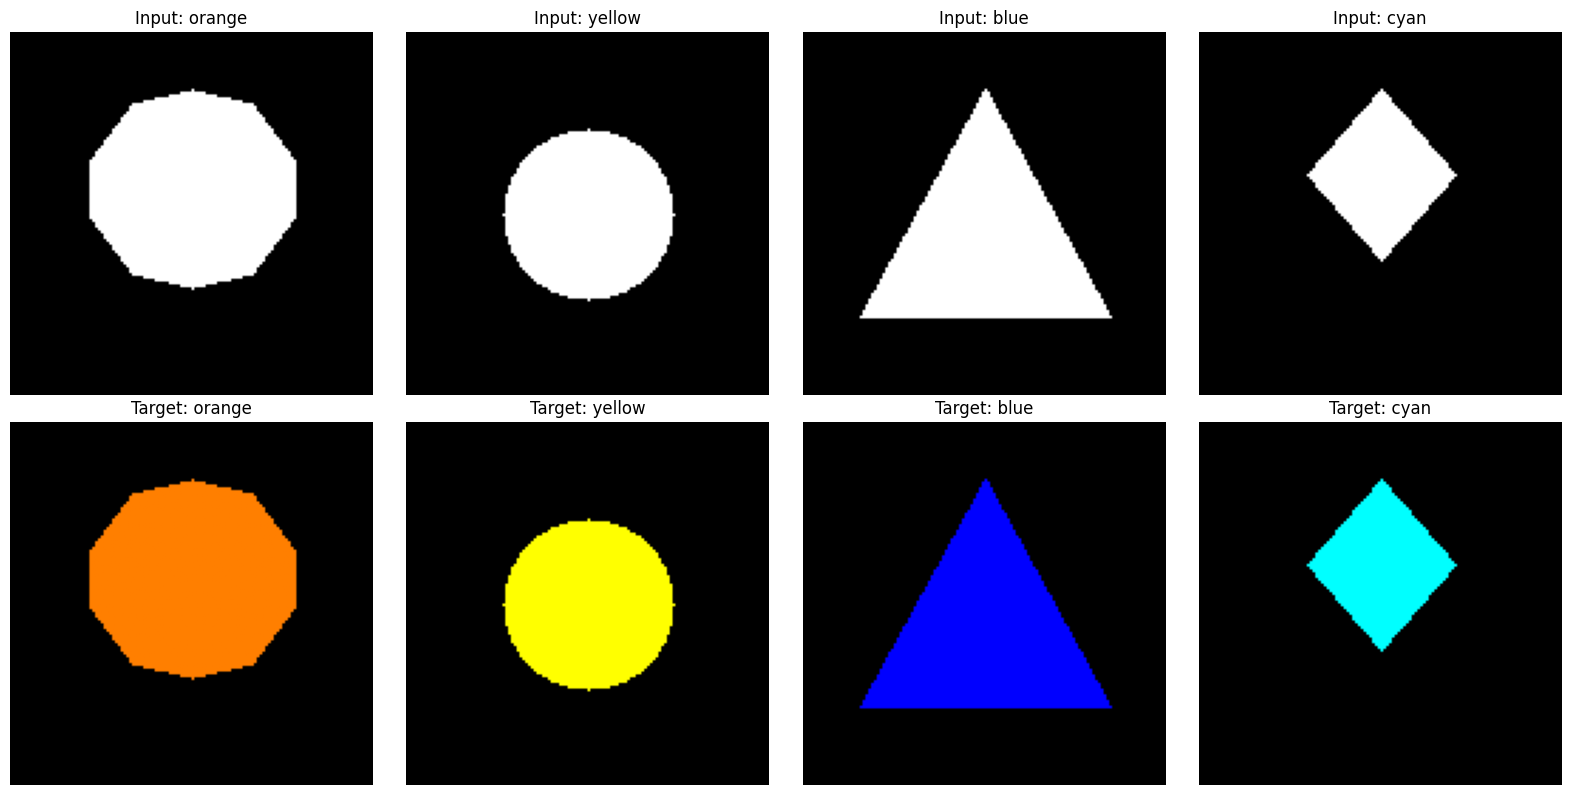

In [14]:
def visualize_batch(data_loader, num_samples=4):
    """Visualize a batch of training data"""
    batch = next(iter(data_loader))

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))

    for i in range(min(num_samples, len(batch['input']))):
        # Input image
        input_img = batch['input'][i].squeeze().numpy()
        axes[0, i].imshow(input_img, cmap='gray')
        axes[0, i].set_title(f'Input: {batch["color_name"][i]}')
        axes[0, i].axis('off')

        # Target image
        target_img = batch['target'][i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(target_img)
        axes[1, i].set_title(f'Target: {batch["color_name"][i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training samples:")
visualize_batch(train_loader)


In [15]:
model = UNet(in_channels=65, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)


In [16]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 31,079,875
Trainable parameters: 31,079,875


In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc='Training')

    for batch in progress_bar:
        # Move data to device
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        color_indices = batch['color_idx'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs, color_indices)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            # Move data to device
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            color_indices = batch['color_idx'].to(device)

            # Forward pass
            outputs = model(inputs, color_indices)
            loss = criterion(outputs, targets)

            # Update metrics
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches


In [18]:
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step(val_loss)

    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_unet_model.pth')
        print(f"✅ New best model saved! Val Loss: {val_loss:.4f}")

print(" Training completed!")


Starting training for 50 epochs...

Epoch 1/50


Training:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-2954167942.py:117: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:150: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(target_rgb, mode='RGB')
/tmp/ipython-input-2954167942.py:133: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:110: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:124: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:103: DeprecationWarning: 'm

Train Loss: 0.2787, Val Loss: 0.3292, LR: 0.001000
✅ New best model saved! Val Loss: 0.3292

Epoch 2/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Train Loss: 0.2254, Val Loss: 0.6048, LR: 0.001000

Epoch 3/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


Train Loss: 0.1860, Val Loss: 0.3866, LR: 0.001000

Epoch 4/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


Train Loss: 0.1646, Val Loss: 0.3148, LR: 0.001000
✅ New best model saved! Val Loss: 0.3148

Epoch 5/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


Train Loss: 0.1489, Val Loss: 0.2169, LR: 0.001000
✅ New best model saved! Val Loss: 0.2169

Epoch 6/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Train Loss: 0.1311, Val Loss: 0.2472, LR: 0.001000

Epoch 7/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Train Loss: 0.1164, Val Loss: 0.1834, LR: 0.001000
✅ New best model saved! Val Loss: 0.1834

Epoch 8/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Train Loss: 0.1041, Val Loss: 0.1592, LR: 0.001000
✅ New best model saved! Val Loss: 0.1592

Epoch 9/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Train Loss: 0.0907, Val Loss: 0.1102, LR: 0.001000
✅ New best model saved! Val Loss: 0.1102

Epoch 10/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Train Loss: 0.0818, Val Loss: 0.0830, LR: 0.001000
✅ New best model saved! Val Loss: 0.0830

Epoch 11/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


Train Loss: 0.0672, Val Loss: 0.0833, LR: 0.001000

Epoch 12/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Train Loss: 0.0654, Val Loss: 0.0722, LR: 0.001000
✅ New best model saved! Val Loss: 0.0722

Epoch 13/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Train Loss: 0.0673, Val Loss: 0.0933, LR: 0.001000

Epoch 14/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Train Loss: 0.0559, Val Loss: 0.0807, LR: 0.001000

Epoch 15/50


Validating: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


Train Loss: 0.0447, Val Loss: 0.0451, LR: 0.001000
✅ New best model saved! Val Loss: 0.0451

Epoch 16/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]


Train Loss: 0.0407, Val Loss: 0.0353, LR: 0.001000
✅ New best model saved! Val Loss: 0.0353

Epoch 17/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Train Loss: 0.0303, Val Loss: 0.0659, LR: 0.001000

Epoch 18/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Train Loss: 0.0273, Val Loss: 0.0719, LR: 0.001000

Epoch 19/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Train Loss: 0.0216, Val Loss: 0.0275, LR: 0.001000
✅ New best model saved! Val Loss: 0.0275

Epoch 20/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


Train Loss: 0.0206, Val Loss: 0.0182, LR: 0.001000
✅ New best model saved! Val Loss: 0.0182

Epoch 21/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


Train Loss: 0.0183, Val Loss: 0.0152, LR: 0.001000
✅ New best model saved! Val Loss: 0.0152

Epoch 22/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Train Loss: 0.0153, Val Loss: 0.0137, LR: 0.001000
✅ New best model saved! Val Loss: 0.0137

Epoch 23/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Train Loss: 0.0144, Val Loss: 0.0162, LR: 0.001000

Epoch 24/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


Train Loss: 0.0136, Val Loss: 0.0114, LR: 0.001000
✅ New best model saved! Val Loss: 0.0114

Epoch 25/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Train Loss: 0.0183, Val Loss: 0.0110, LR: 0.001000
✅ New best model saved! Val Loss: 0.0110

Epoch 26/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Train Loss: 0.0123, Val Loss: 0.0114, LR: 0.001000

Epoch 27/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Train Loss: 0.0125, Val Loss: 0.0106, LR: 0.001000
✅ New best model saved! Val Loss: 0.0106

Epoch 28/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Train Loss: 0.0108, Val Loss: 0.0098, LR: 0.001000
✅ New best model saved! Val Loss: 0.0098

Epoch 29/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Train Loss: 0.0098, Val Loss: 0.0087, LR: 0.001000
✅ New best model saved! Val Loss: 0.0087

Epoch 30/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Train Loss: 0.0098, Val Loss: 0.0077, LR: 0.001000
✅ New best model saved! Val Loss: 0.0077

Epoch 31/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Train Loss: 0.0090, Val Loss: 0.0067, LR: 0.001000
✅ New best model saved! Val Loss: 0.0067

Epoch 32/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Train Loss: 0.0105, Val Loss: 0.0074, LR: 0.001000

Epoch 33/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Train Loss: 0.0103, Val Loss: 0.0092, LR: 0.001000

Epoch 34/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Train Loss: 0.0098, Val Loss: 0.0091, LR: 0.001000

Epoch 35/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Train Loss: 0.0078, Val Loss: 0.0074, LR: 0.001000

Epoch 36/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


Train Loss: 0.0079, Val Loss: 0.0064, LR: 0.001000
✅ New best model saved! Val Loss: 0.0064

Epoch 37/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Train Loss: 0.0067, Val Loss: 0.0055, LR: 0.001000
✅ New best model saved! Val Loss: 0.0055

Epoch 38/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Train Loss: 0.0063, Val Loss: 0.0052, LR: 0.001000
✅ New best model saved! Val Loss: 0.0052

Epoch 39/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Train Loss: 0.0078, Val Loss: 0.0048, LR: 0.001000
✅ New best model saved! Val Loss: 0.0048

Epoch 40/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


Train Loss: 0.0066, Val Loss: 0.0057, LR: 0.001000

Epoch 41/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Train Loss: 0.0067, Val Loss: 0.0051, LR: 0.001000

Epoch 42/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


Train Loss: 0.0058, Val Loss: 0.0043, LR: 0.001000
✅ New best model saved! Val Loss: 0.0043

Epoch 43/50


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Train Loss: 0.0067, Val Loss: 0.0052, LR: 0.001000

Epoch 44/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Train Loss: 0.0054, Val Loss: 0.0051, LR: 0.001000

Epoch 45/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Train Loss: 0.0067, Val Loss: 0.0049, LR: 0.001000

Epoch 46/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


Train Loss: 0.0060, Val Loss: 0.0042, LR: 0.001000
✅ New best model saved! Val Loss: 0.0042

Epoch 47/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Train Loss: 0.0052, Val Loss: 0.0050, LR: 0.001000

Epoch 48/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Train Loss: 0.0052, Val Loss: 0.0051, LR: 0.001000

Epoch 49/50


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Train Loss: 0.0059, Val Loss: 0.0040, LR: 0.001000
✅ New best model saved! Val Loss: 0.0040

Epoch 50/50


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]

Train Loss: 0.0048, Val Loss: 0.0042, LR: 0.001000

🎉 Training completed!


Testing inference on validation data:


/tmp/ipython-input-2954167942.py:110: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:150: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(target_rgb, mode='RGB')
/tmp/ipython-input-2954167942.py:133: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:124: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')
/tmp/ipython-input-2954167942.py:117: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img, mode='L')


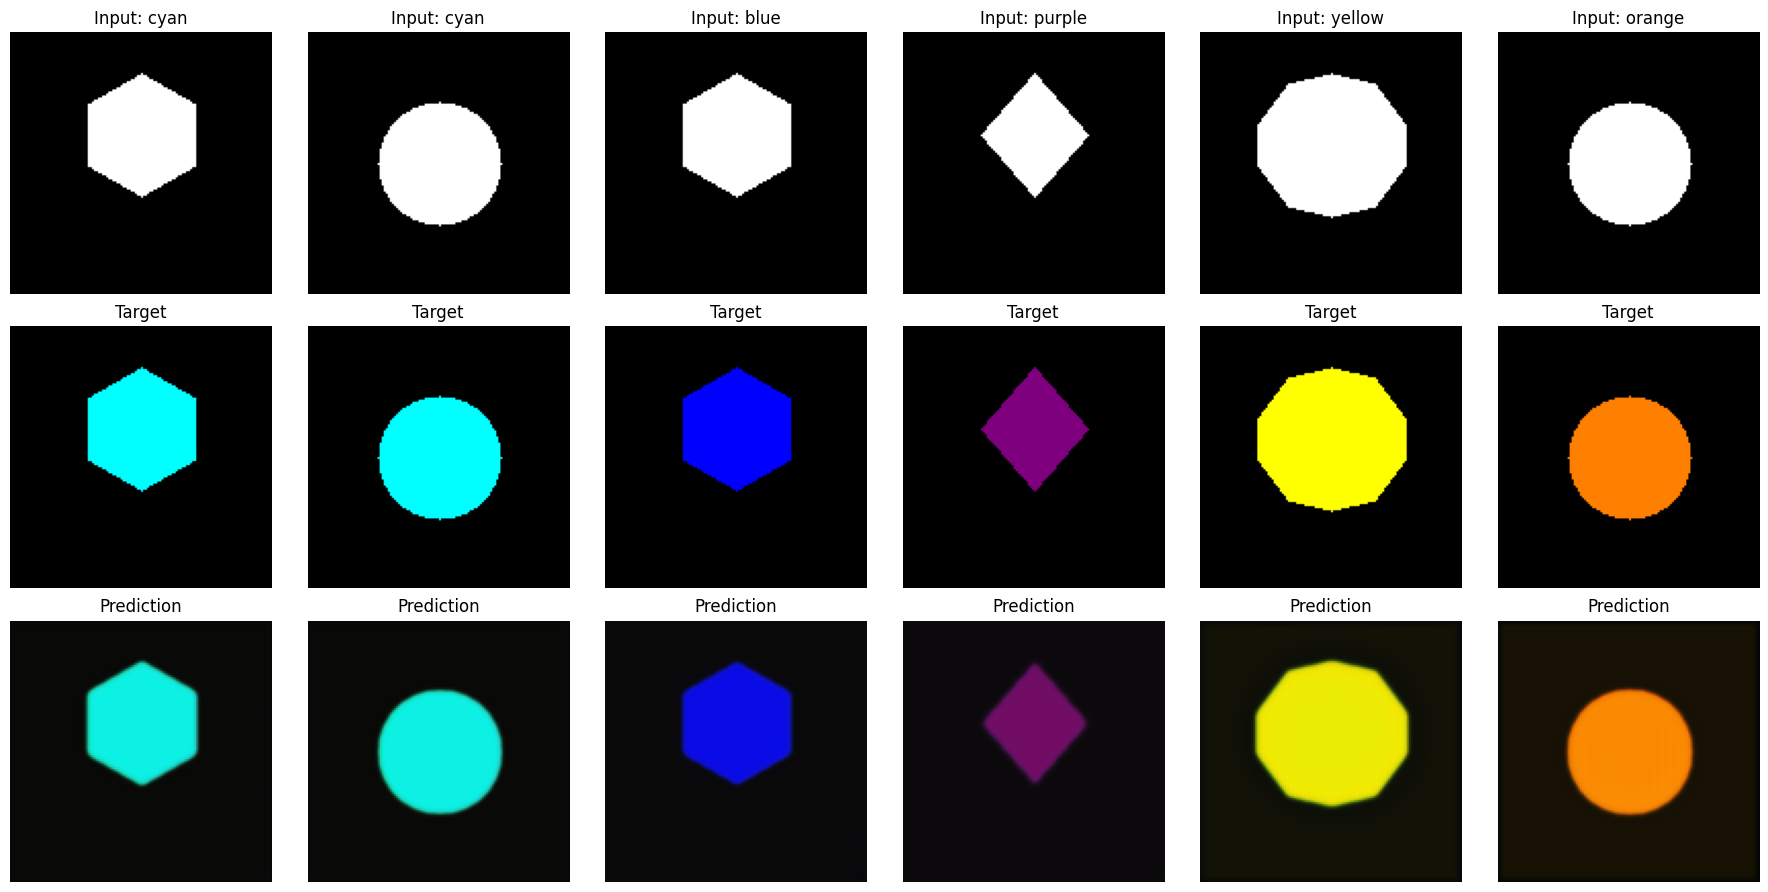

In [19]:
def test_inference(model, val_loader, device, num_samples=6):
    """Test inference on validation data"""
    model.eval()

    # Get a batch
    batch = next(iter(val_loader))

    with torch.no_grad():
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        color_indices = batch['color_idx'].to(device)

        # Get predictions
        outputs = model(inputs, color_indices)

    # Visualize results
    fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))

    for i in range(min(num_samples, len(inputs))):
        # Input
        input_img = inputs[i].cpu().squeeze().numpy()
        axes[0, i].imshow(input_img, cmap='gray')
        axes[0, i].set_title(f'Input: {batch["color_name"][i]}')
        axes[0, i].axis('off')

        # Target
        target_img = targets[i].cpu().permute(1, 2, 0).numpy()
        axes[1, i].imshow(target_img)
        axes[1, i].set_title('Target')
        axes[1, i].axis('off')

        # Prediction
        pred_img = outputs[i].cpu().permute(1, 2, 0).numpy()
        pred_img = np.clip(pred_img, 0, 1)
        axes[2, i].imshow(pred_img)
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Load best model and test
checkpoint = torch.load('best_unet_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Testing inference on validation data:")
test_inference(model, val_loader, device)


In [20]:
torch.save({
    'model_state_dict': model.state_dict(),
    'color_map': train_dataset.color_map,
    'color_rgb': train_dataset.color_rgb,
    'image_size': 128,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'best_val_loss': best_val_loss
}, 'unet_model_final.pth')

print("✅ Final model saved as 'unet_model_final.pth'")

# Download the model
files.download('unet_model_final.pth')
files.download('best_unet_model.pth')

print("Training complete! Model files downloaded.")

✅ Final model saved as 'unet_model_final.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete! Model files downloaded.
